In [25]:
import numpy as np
import vedo
import os
from tqdm import tqdm
from MeshObject import *
import pandas as pd
from Pipeline import *

shape_path_orig = "../ShapeDatabase_INFOMR_orig"
# HISTOGRAM FOR EACH NORMALIZATION STEP
# FOR PCA STEP - COMPUTE PCA FIRST, THEN COMPUTE PCA SECOND TIME ON ALIGNED SHAPE = IF DOT PRODUCT IS 1 FOR ONE (OR ALL?) AXIS - IT'S ALL GOOD

In [26]:
def object_statistics(mesh: MeshObject):
    return {
        "name": mesh.name,
        "class": mesh.class_type,
        "nfaces": mesh.n_faces,
        "nvertices": mesh.n_vertices,
        "face_type": mesh.face_type,
        "bounding_box": mesh.bounding_box
    }

def dataset_statistics(shape_path):
    #### BOUNDING BOX!! AXIS ALIGNED VIA XMAX-XMIN - compare with builtin bounds()
    stats = {
        "name": [],
        "class": [],
        "nfaces": [],
        "nvertices": [],
        "face_type": [],
        "bounding_box": []
    }

    # remove any directories that might not contain .obj files
    classes = [class_type for class_type in os.listdir(shape_path_orig) if os.path.isdir((os.path.join(shape_path_orig, class_type))) and class_type != ".git"]
    for class_type in tqdm(classes):
        class_path = os.path.join(shape_path_orig, class_type)

        for obj_name in os.listdir(class_path):
            obj_path = os.path.join(class_path, obj_name)
            obj = MeshObject(obj_path, False, name=obj_name, class_type=class_type)

            # add to global dictionary
            obj_stats = object_statistics(obj)
            for attribute in stats.keys():
                stats[attribute].append(obj_stats[attribute]) 

    return stats

stats = dataset_statistics(shape_path_orig)

100%|██████████| 69/69 [00:50<00:00,  1.35it/s]


In [27]:
df = pd.DataFrame(stats)
# df.to_csv("original_data_statistics.csv", index=False)
df.to_pickle("original_data_statistics.pickle")
df

,name,class,nfaces,nvertices,face_type,bounding_box
0,m433.obj,House,4236,2380,triangle,"[0.025, 0.975, 0.025, 0.224068, 0.025, 0.888636]"
1,m440.obj,House,906,411,triangle,"[0.025, 0.651804, 0.025, 0.465722, 0.025, 0.975]"
2,m448.obj,House,1502,762,triangle,"[0.025, 0.714563, 0.025, 0.975, 0.025, 0.899309]"
3,D00359.obj,House,66144,35522,triangle,"[-1.01194, 0.722748, -0.933903, 0.827164, -0.4..."
4,D00389.obj,House,50407,27493,triangle,"[-1.08453, 0.749038, -0.830679, 0.871337, -0.4..."
...,...,...,...,...,...,...
2478,m666.obj,Gun,26860,13440,triangle,"[0.025, 0.975, 0.025, 0.69407, 0.025, 0.267973]"
2479,D00929.obj,Gun,1394,1026,triangle,"[-0.822144, 1.02365, -0.551779, 0.602898, -0.1..."
2480,m664.obj,Gun,9270,4651,triangle,"[0.025, 0.975, 0.025, 0.721188, 0.025, 0.199559]"
2481,m650.obj,Gun,2464,1460,triangle,"[0.025, 0.975, 0.025, 0.660075, 0.025, 0.158238]"


# Finding different shapes accroding to vertex/face count

In [28]:
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [29]:
avg_vertex_num = np.mean(df.nvertices)
avg_face_num = np.mean(df.nfaces)

vertex_avg = np.argmin([abs(shape-avg_vertex_num) for shape in df.nvertices.to_numpy()])
face_avg = np.argmin([abs(shape-avg_face_num) for shape in df.nfaces.to_numpy()])

vertex_min = np.argmin(df.nvertices.to_numpy())
face_min = np.argmin(df.nfaces.to_numpy())

vertex_max = np.argmax(df.nvertices.to_numpy())
face_max = np.argmax(df.nfaces.to_numpy())

print(f"ID of shape with an average count of vertices {vertex_avg}={df.iloc[vertex_avg].nvertices}, with the average number being {avg_vertex_num:.3f}")
print(f"ID of shape with an average count of vertices {face_avg}={df.iloc[face_avg].nfaces}, with the average number being {avg_face_num:.3f}")
print("-----------------")
print(f"ID of shape with lowest count of vertices {vertex_min}={df.iloc[vertex_min].nvertices}")
print(f"ID of shape with lowest count of faces {face_min}={df.iloc[face_min].nfaces}")
print("-----------------")
print(f"ID of shape with highest count of vertices {vertex_max}={df.iloc[vertex_max].nvertices}")
print(f"ID of shape with highest count of faces {face_max}={df.iloc[face_max].nfaces}")

ID of shape with an average count of vertices 2218=5602, with the average number being 5609.783
ID of shape with an average count of vertices 1921=10692, with the average number being 10691.526
-----------------
ID of shape with lowest count of vertices 761=16
ID of shape with lowest count of faces 761=16
-----------------
ID of shape with highest count of vertices 1406=98256
ID of shape with highest count of faces 1959=129881


## Average shape

In [30]:
avg_shape_vertex = df.iloc[vertex_avg]
avg_shape_face = df.iloc[face_avg]
avg_shape_vertex, avg_shape_face

(name                                                   D00926.obj
 class                                                       Truck
 nfaces                                                      39495
 nvertices                                                    5602
 face_type                                                triangle
 bounding_box    [9.17465, 11.7069, 0.0, 19.3774, 0.00170373, 4...
 Name: 2218, dtype: object,
 name                                                m1659.obj
 class                                                    City
 nfaces                                                  10692
 nvertices                                                5804
 face_type                                            triangle
 bounding_box    [0.025, 0.975, 0.025, 0.345009, 0.025, 0.975]
 Name: 1921, dtype: object)

In [31]:
mesh = MeshObject(os.path.join(shape_path_orig, avg_shape_vertex["class"], avg_shape_vertex["name"]), visualize=True)
mesh.plotter.title = "Average shape in terms of number of vertices"
mesh.show()

In [32]:
mesh = MeshObject(os.path.join(shape_path_orig, avg_shape_face["class"], avg_shape_face["name"]), visualize=True)
mesh.plotter.title = "Average shape in terms of number of faces"
mesh.show()

## Minimum shape

In [33]:
min_shape_vertex = df.iloc[vertex_min]
min_shape_face = df.iloc[face_min]
min_shape_vertex, min_shape_face

(name                                                   D01121.obj
 class                                                        Door
 nfaces                                                         16
 nvertices                                                      16
 face_type                                                triangle
 bounding_box    [0.025, 0.567857, 0.025, 0.975, 0.025, 0.0521429]
 Name: 761, dtype: object,
 name                                                   D01121.obj
 class                                                        Door
 nfaces                                                         16
 nvertices                                                      16
 face_type                                                triangle
 bounding_box    [0.025, 0.567857, 0.025, 0.975, 0.025, 0.0521429]
 Name: 761, dtype: object)

In [34]:
mesh = MeshObject(os.path.join(shape_path_orig, min_shape_vertex["class"], min_shape_vertex["name"]), visualize=True)
mesh.plotter.title = "Smallest shape in terms of number of vertices"
mesh.show()

In [35]:
mesh = MeshObject(os.path.join(shape_path_orig, min_shape_face["class"], min_shape_face["name"]), visualize=True)
mesh.plotter.title = "Smallest shape in terms of number of faces"
mesh.show()

## Maximum

In [36]:
max_shape_vertex = df.iloc[vertex_max]
max_shape_face = df.iloc[face_max]
max_shape_vertex, max_shape_face

(name                                                   D00159.obj
 class                                                PlantIndoors
 nfaces                                                      32752
 nvertices                                                   98256
 face_type                                                triangle
 bounding_box    [-1.02299, 0.735003, -0.76005, 0.812815, -0.76...
 Name: 1406, dtype: object,
 name                                                   m1120.obj
 class                                                    Biplane
 nfaces                                                    129881
 nvertices                                                  65722
 face_type                                               triangle
 bounding_box    [0.025, 0.975, 0.025, 0.370037, 0.025, 0.889139]
 Name: 1959, dtype: object)

In [37]:
mesh = MeshObject(os.path.join(shape_path_orig, max_shape_vertex["class"], max_shape_vertex["name"]), visualize=True)
mesh.plotter.title = "Biggest shape in terms of number of vertices"
mesh.show()

In [38]:
mesh = MeshObject(os.path.join(shape_path_orig, max_shape_face["class"], max_shape_face["name"]), visualize=True)
mesh.plotter.title = "Biggest shape in terms of number of faces"
mesh.show()

In [39]:
df[df["class"] == "Skyscraper"].nvertices.max()

np.int64(73697)

# Overall statistics

In [28]:
def plot_attribute(df, attribute_x, attribute_y, estimator):
    label_name_map = {
        "nvertices": "vertices",
        "nfaces": "faces",
        "class": "shapes"
    }

    aux_df = df
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(16,9))
    if type(df[attribute_y].iloc[0]) is not str:
        mean_value_attribute = round(np.mean(df[attribute_y]))
        aux_df = df.sort_values(attribute_x, ascending=False).reset_index(drop=True)
        sns.barplot(data=aux_df, x=attribute_x, y=attribute_y, estimator=estimator) # switch to sum/mean - mean might not be best?
    else:
        mean_value_attribute = round(np.mean(aux_df["class"].value_counts()))
        sns.countplot(data=aux_df, x=attribute_x, order=aux_df["class"].value_counts().index) # switch to sum/mean - mean might not be best?
        
    plt.xticks(rotation=90)
    sns.despine()
    if type(df[attribute_y].iloc[0]) is not str:
        plt.text(x=64, y=mean_value_attribute + mean_value_attribute*0.1, s=f"{mean_value_attribute}", color="red")
    else:
        plt.text(x=64, y=mean_value_attribute + 2, s=f"{mean_value_attribute}", color="red")

    plt.hlines(y=mean_value_attribute, xmin=-1, xmax=69, colors="red", linestyles="dashed")
    plt.xlim((-1,69))
    plt.xlabel("Class")
    plt.ylabel(f"Number of {label_name_map[attribute_y]}")
    name = f"beforenorm_{attribute_x}_{attribute_y}_plot.png"
    plt.savefig(name)
    plt.show()

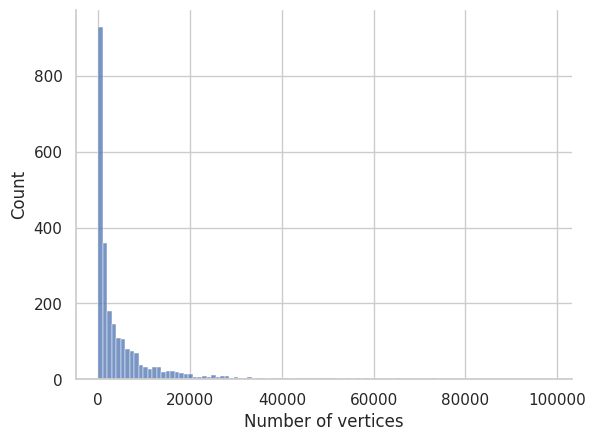

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.histplot(x=df["nvertices"], bins=100)
plt.xlabel("Number of vertices")
sns.despine()
plt.savefig("nvertices_before.png")

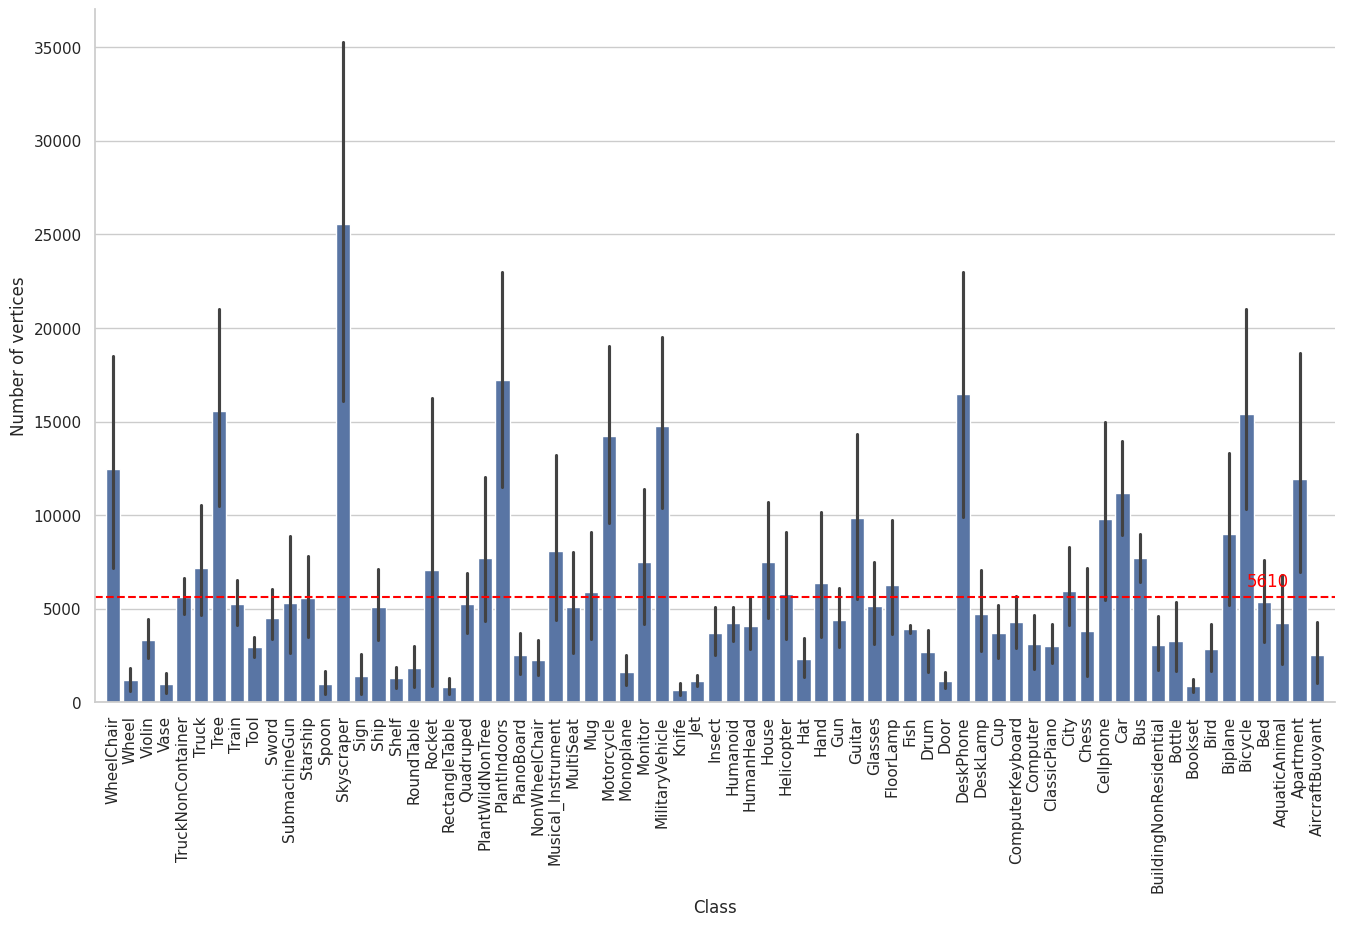

In [31]:
plot_attribute(df, "class", "nvertices", "mean")

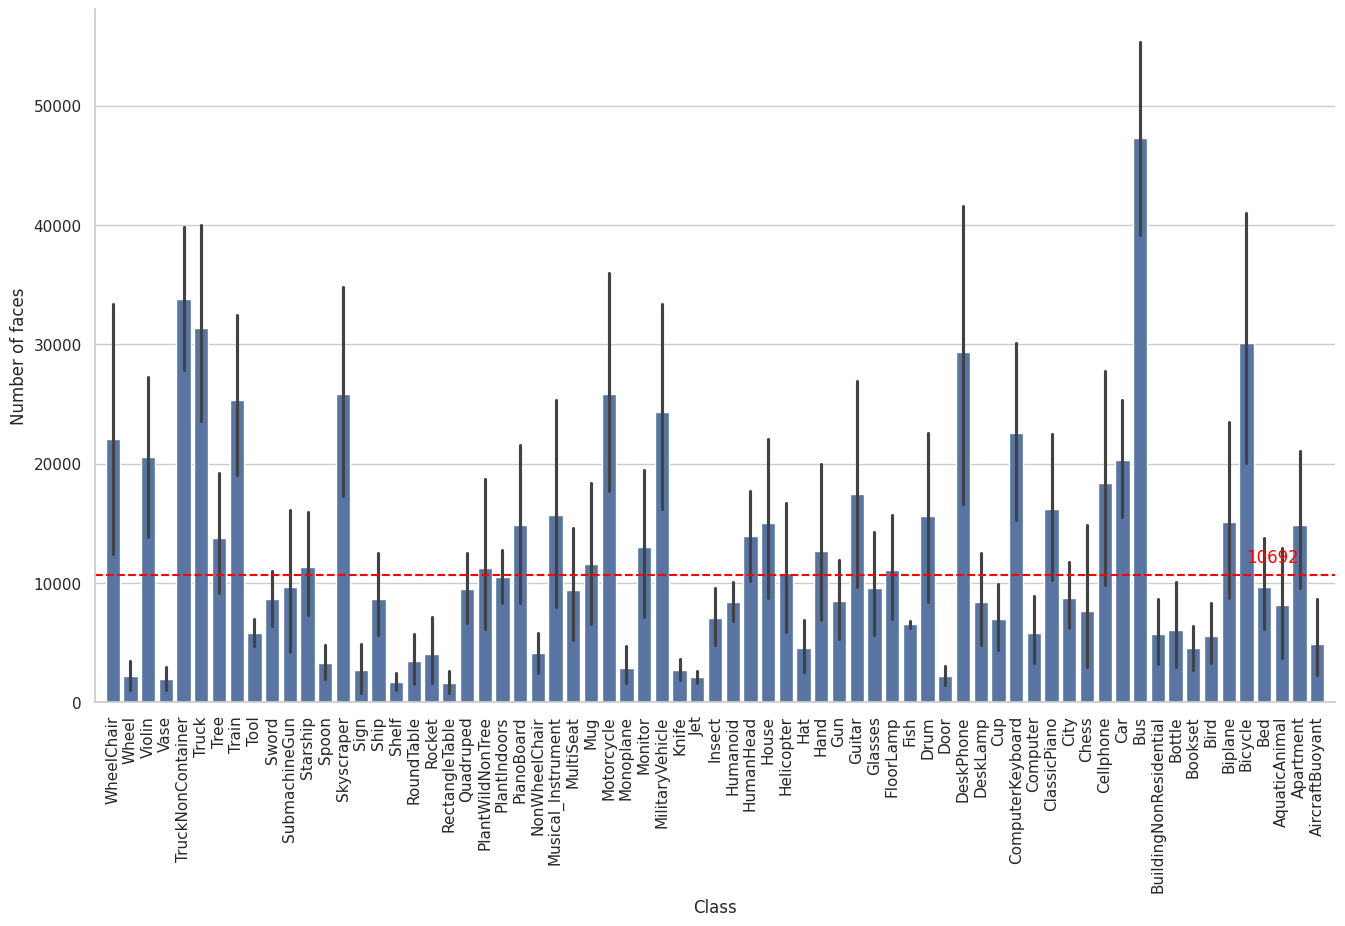

In [32]:
plot_attribute(df, "class", "nfaces", "mean")

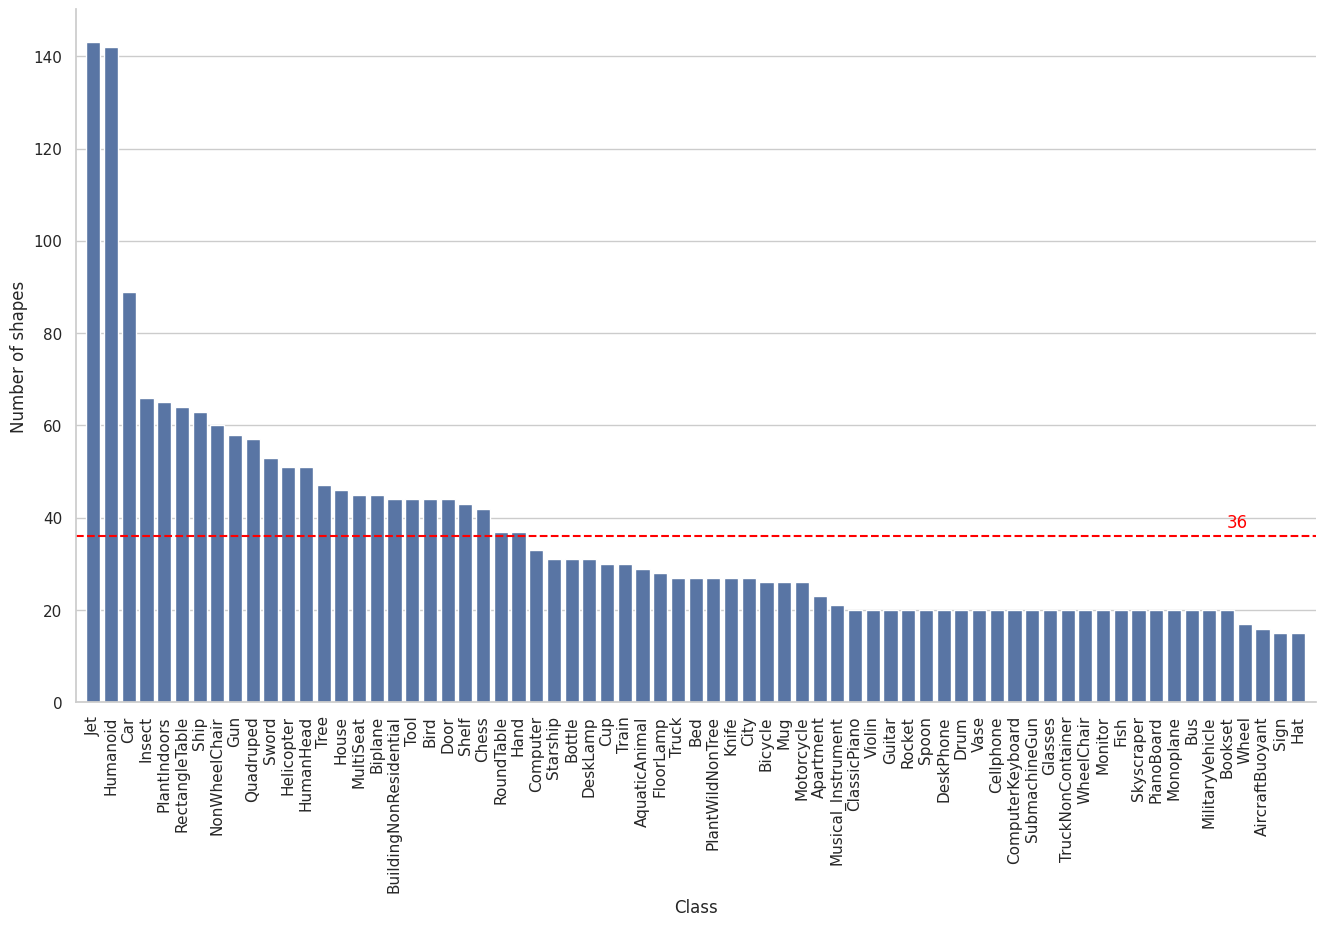

In [34]:
plot_attribute(df, "class", "class", None)

In [45]:
df[(df["nfaces"] < 100) | (df["nvertices"] < 100)].to_pickle("outliers_dataset.pickle")

In [46]:
import pickle
import pandas as pd

df = pd.read_pickle("original_data_statistics.pickle")
df_outliers = pd.read_pickle("outliers_dataset.pickle")
df_outliers

,name,class,nfaces,nvertices,face_type,bounding_box
31,m434.obj,House,26,22,triangle,"[0.025, 0.658333, 0.025, 0.975, 0.025, 0.975]"
40,m423.obj,House,48,35,triangle,"[0.025, 0.975, 0.025, 0.309109, 0.025, 0.390835]"
41,m462.obj,House,22,25,triangle,"[0.025, 0.680247, 0.025, 0.60382, 0.025, 0.975]"
181,m782.obj,MultiSeat,46,40,triangle,"[0.025, 0.975, 0.025, 0.42384, 0.025, 0.347871]"
195,m836.obj,MultiSeat,44,28,triangle,"[0.025, 0.975, 0.025, 0.5, 0.025, 0.5]"
...,...,...,...,...,...,...
2189,m1097.obj,Tree,31,35,triangle,"[0.025, 0.418527, 0.025, 0.975, 0.025, 0.02842]"
2207,m1082.obj,Tree,140,82,triangle,"[0.025, 0.457911, 0.025, 0.975, 0.025, 0.436723]"
2259,m59.obj,AquaticAnimal,1680,44,triangle,"[0.025, 0.225, 0.025, 0.225, 0.025, 0.975]"
2338,m1102.obj,Tool,52,24,triangle,"[0.025, 0.201067, 0.025, 0.975, 0.025, 0.056667]"



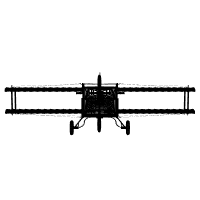

In [47]:
def _subdivide_shape(vedo_mesh: MeshObject, subdivision_type: str="centroid", threshold: int=5610):
        if not vedo_mesh.is_manifold():
            return vedo_mesh
        
        match subdivision_type:
            case "loop":
                subdivision_type = 0
            case "linear":
                subdivision_type = 1
            case "adaptive":
                subdivision_type = 2
            case "butterfly":
                subdivision_type = 3
            case "centroid":
                subdivision_type = 4
        last_vertex_count = -1
        while vedo_mesh.n_vertices < threshold:
            vedo_mesh = vedo_mesh.subdivide(1, method=subdivision_type)
            if last_vertex_count == vedo_mesh.n_vertices:
                break
            last_vertex_count = vedo_mesh.n_vertices
        vedo_mesh.decimate(0.5, threshold)

        return vedo_mesh

_subdivide_shape(mesh)

In [4]:
import numpy as np
import vedo
import os
from tqdm import tqdm
from MeshObject import *
import pandas as pd
from Pipeline import *

# HISTOGRAM FOR EACH NORMALIZATION STEP
# FOR PCA STEP - COMPUTE PCA FIRST, THEN COMPUTE PCA SECOND TIME ON ALIGNED SHAPE = IF DOT PRODUCT IS 1 FOR ONE (OR ALL?) AXIS - IT'S ALL GOOD

# from processing_functions import subdivide_shape

import pickle
import pandas as pd

df = pd.read_pickle("original_data_statistics.pickle")

from Pipeline import *

shape_path_orig = "../ShapeDatabase_INFOMR_orig"
pipeline = Pipeline(pipeline_parameters={"subdivide": {"threshold": 5610, "subdivision_type": "centroid"}})

from collections import defaultdict, Counter
new_path_shape = "../ShapeDatabase_INFOMR"
nontwomanifold_faces = defaultdict(list)
class_type, obj_name = "", ""
iterator = tqdm(zip(df["class"], df["name"]), total=len(df), desc=f"{class_type} - {obj_name}")
ok = []
for class_type, obj_name in iterator:
    path = os.path.join(shape_path_orig, class_type, obj_name)
    new_path = os.path.join(new_path_shape, class_type, obj_name)
    mesh = MeshObject(path, True, class_type=class_type, name=obj_name)
    if not mesh.is_manifold():
        nontwomanifold_faces[class_type] += [obj_name]
    mesh: MeshObject = pipeline.normalize_shape(mesh)

    # if mesh.is_manifold():
    # else:
    #     nontwomanifold_faces[class_type] += [obj_name]
        # mesh = mesh.non_manifold_faces(tol=0).fill_holes()
        # mesh: MeshObject = pipeline.normalize_shape(mesh)

    iterator.set_description(f"{class_type} - {obj_name}")
    vedo.save(mesh, new_path)


Gun - m685.obj: 100%|██████████| 2483/2483 [09:22<00:00,  4.41it/s]                   


In [9]:
total = 0
for class_type, obj_list in nontwomanifold_faces.items():
    print(f"{class_type}={len(obj_list)}")
    total += len(obj_list)

print(f"Number of nonmanifold objects={total}")

House=27
Car=61
ClassicPiano=20
Apartment=13
MultiSeat=10
Humanoid=83
Spoon=20
Helicopter=32
DeskPhone=6
Quadruped=28
Rocket=1
RoundTable=11
Guitar=13
Vase=4
Jet=75
Door=14
NonWheelChair=18
Mug=4
Drum=20
AircraftBuoyant=5
FloorLamp=5
Hand=4
Train=25
RectangleTable=19
Monitor=8
Starship=23
Violin=20
Cellphone=10
Bird=18
TruckNonContainer=20
Knife=21
ComputerKeyboard=20
WheelChair=7
Bottle=3
PlantIndoors=13
Bicycle=19
Cup=3
Shelf=17
Ship=39
Fish=17
PianoBoard=20
Skyscraper=9
Sword=23
HumanHead=35
Wheel=3
BuildingNonResidential=26
MilitaryVehicle=13
Insect=20
Hat=5
City=27
PlantWildNonTree=8
Biplane=23
Computer=12
SubmachineGun=10
Bookset=20
DeskLamp=9
Chess=12
Bed=13
Tree=15
Truck=25
AquaticAnimal=14
Musical_Instrument=13
Glasses=3
Tool=10
Bus=20
Monoplane=5
Motorcycle=11
Gun=31
Number of nonmanifold objects=1211


In [ ]:
from MeshObject import *
import pymeshfix
import pymeshlab
shape_path_orig = "../ShapeDatabase_INFOMR_orig"

mesh = MeshObject(shape_path_orig + "/ClassicPiano/D00314.obj", visualize=True)

# mesh = MeshObject(shape_path_orig + "/Door/D01121.obj", visualize=True)
# plt1 = Plotter()
# plt1 += [mesh]
# plt1.show()

# pymesh = vedo.utils.vedo2meshlab(mesh)
# pymesh_set = pymeshlab.MeshSet()
# pymesh_set.add_mesh(pymesh)
# pymesh_set.meshing_remove_duplicate_faces()
# pymesh_set.meshing_remove_duplicate_vertices()
# pymesh_set.meshing_repair_non_manifold_edges(method=0)
# pymesh_set.meshing_repair_non_manifold_vertices()
# mesh = MeshObject(pymesh_set.current_mesh(), visualize=True)


# # fix.plot(show_holes=False)
# # fix.repair(verbose=True, joincomp=True, remove_smallest_components=False)
# # mesh = MeshObject(fix.mesh, visualize=True)
# # mesh.show()
# # mesh.non_manifold_faces(remove=False, tol=0)
# del pymesh_set
# mesh = MeshObject(pymesh_set.current_mesh(), visualize=True)

# mesh.decimate(n=5600)

meshing_remove_duplicate_faces
10349 6800 False
meshing_remove_duplicate_vertices
10349 6800 False
meshing_repair_non_manifold_edges
10292 6800 True
meshing_repair_non_manifold_vertices
10292 6992 True
BEFORE Flat
NOW Gouraud
BEFORE Gouraud
NOW Phong
BEFORE Phong
NOW Flat
Press 'o' again to rotate light source, or 'O' to remove it.
BEFORE Flat
NOW Gouraud
BEFORE Gouraud
NOW Phong
BEFORE Phong
NOW Flat
BEFORE Flat
NOW Gouraud


[13595 12773 12772] [0.41271    0.12171367 0.78834967]
[16018 16017 16019] [0.41418867 0.12214567 0.75150933]
[12772 13595 12773] [0.41283867 0.121751   0.78845767]
[16018 16017 16019] [0.41400233 0.12209133 0.75165367]
[12785 12784 12790] [0.41354567 0.12195767 0.767397  ]
[13595 12773 12772] [0.412714   0.12171467 0.788353  ]
[13595 12773 12772] [0.412714   0.12171467 0.788353  ]
[12785 12784 12790] [0.41354567 0.12195767 0.767397  ]
[14268 14243 14053] [0.44017    0.13918733 0.82270133]
[14268 14243 14053] [0.44014433 0.139085   0.82271467]
[14268 14243 14053] [0.440145   0.139087   0.82271433]
[14250 14051 14248] [0.42767167 0.129004   0.802014  ]
[14250 14051 14248] [0.42869867 0.12958967 0.803537  ]
[14250 14051 14248] [0.42806367 0.12897133 0.802436  ]
[14250 14051 14248] [0.42869867 0.12958967 0.803537  ]


[vedo.mesh:461] INFO: 
 --------- Non manifold faces ---------
 Average tol.   :  0.8139 +-  0.3717
 Automatic tol. :  0.1628
 Removed faces  : 15
 Recovered faces: 0



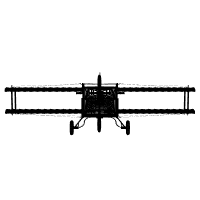

In [ ]:
mesh = MeshObject(shape_path_orig + "/Biplane/m1120.obj", visualize=True)
mesh.non_manifold_faces(remove=False)